In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# read dirs
import os

## Strategy: Buy the dip
- 1分足で1%以上の下落を検知(t0)
- 検知対象足（t0）のCloseに対しexpire1mとしbest_bidで指値
- 1分経過後約定していれば、（t1）Closeに対しexpire1mとしbest_askで指値
- 決済約定が完了するまで繰り返す

以下で検討する。
結論から言うと、収益機会は少ないものの成行手数料で考慮しても実装に値する。検証の結果、2024年下半期で手数料考慮後2.5%程度の利益を見込める。
エントリー最適化すれば、さらに収益性が見込める。

ちなみに、魔鍛造USDなどをステークすると年間20%前後の収益を見込める（カウンターパーティーリスクは考慮しないものとする）。

下記に変数を記載する。
インクリメントなどで変更し、プロットすることで過去データに則した最適値が見つかる。傾向としては、ボラティリティは減少中。

※ 指値であれば、手数料コスト低下、約定可能性考慮コスト発生
※ 成り行きであれば、スプレッド・手数料コスト増加、実装コスト低

In [75]:
# VIP 0= 0.0002, 1=0.00018, 2=0.00016, 3=0.000014, 4=0.000012, 5=0.00001, Pro 1=0.0001, 2=0.00005
fee_rate = 0.00055

# Target dips ratio
DipsRatio = -0.01

# TargetTimeForMinutes 
TargetTimeForMinutes = 1

In [76]:
# import data dirs from the data directory
data_dir = os.path.join(os.getcwd(), 'data')

In [77]:
# read th data file from the data directory, with csv.gz extension
files = [f for f in os.listdir(data_dir) if f.endswith('.csv.gz')]
print(files)

['BTCUSDT_1_2024-07-01_2024-07-31.csv.gz', 'BTCUSDT_1_2024-08-01_2024-08-31.csv.gz', 'BTCUSDT_1_2024-09-01_2024-09-30.csv.gz', 'BTCUSDT_1_2024-10-01_2024-10-31.csv.gz', 'BTCUSDT_1_2024-11-01_2024-11-30.csv.gz', 'BTCUSDT_1_2024-12-01_2024-12-31.csv.gz']


In [78]:
# read the data file
# comfirm data columns
temp = pd.read_csv(os.path.join(data_dir, files[0]))
print(temp.columns)

Index(['2024.07.01 00:00', '61942.1', '61965.7', '61930.1', '61954.3',
       '44.628'],
      dtype='object')


In [79]:
# read ohlcv data from files
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
ohlcvs = []
for file in files:
    temp = pd.read_csv(os.path.join(data_dir, file))
    temp.columns = columns
    ohlcvs.append(temp)

In [80]:
# to pndas data frame
ohlcvs = pd.concat(ohlcvs)
ohlcvs.describe()

,open,high,low,close,volume
count,264960.000000,264960.000000,264960.000000,264960.000000,264960.000000
mean,72149.543004,72180.308696,72118.799115,72149.662655,89.909737
std,15701.640229,15709.689216,15693.578613,15701.683330,172.985709
min,49382.100000,49811.400000,48914.100000,49382.100000,0.193000
25%,60277.775000,60306.000000,60250.100000,60277.775000,20.261000
50%,65520.150000,65541.050000,65502.750000,65520.200000,42.404000
75%,90405.050000,90456.900000,90353.350000,90405.700000,93.279750
max,108281.300000,108421.600000,108177.500000,108281.300000,9891.362000


In [81]:
# first culumn is 2024/7, end column is 2024/12
# comfirm the data
print(ohlcvs.iloc[0])  # first row
print(ohlcvs.iloc[-1])  # last row

timestamp    2024.07.01 00:01
open                  61954.3
high                  61973.8
low                   61950.0
close                 61973.7
volume                  12.99
Name: 0, dtype: object
timestamp    2025.01.01 00:00
open                  93537.7
high                  93724.6
low                   93533.1
close                 93657.1
volume                158.733
Name: 44639, dtype: object


count    264960.000000
mean      72149.662655
std       15701.683330
min       49382.100000
25%       60277.775000
50%       65520.200000
75%       90405.700000
max      108281.300000
Name: close, dtype: float64


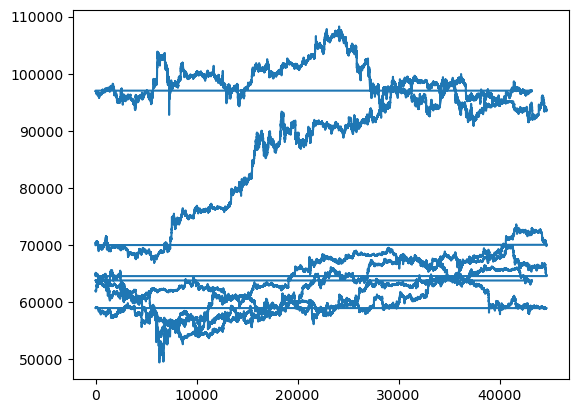

In [82]:
# chart for close price
print(ohlcvs['close'].describe())
plt.plot(ohlcvs['close'])

In [83]:
shift1m = ohlcvs['close'].shift(TargetTimeForMinutes)
diff1m = (ohlcvs['close'] - shift1m) / shift1m
print(diff1m.describe())

count    264959.000000
mean          0.000002
std           0.000756
min          -0.035180
25%          -0.000335
50%           0.000000
75%           0.000338
max           0.028628
Name: close, dtype: float64


In [84]:
# 1分後の変動を取得
ohlcvs['entry_close'] = ohlcvs['close'].shift(-TargetTimeForMinutes)
ohlcvs['target_close'] = ohlcvs['close'].shift(-(TargetTimeForMinutes * 2))

In [85]:
# 1分後の変動が0.01以上の場合
ohlcvs['flag_diff'] = (ohlcvs['entry_close'] - ohlcvs['close']) / ohlcvs['close']
ohlcvs['entry_diff'] = (ohlcvs['target_close'] - ohlcvs['entry_close']) / ohlcvs['entry_close']
ohlcvs['filtered'] = ohlcvs['flag_diff'] < DipsRatio

10
Axes(0.125,0.11;0.775x0.77)


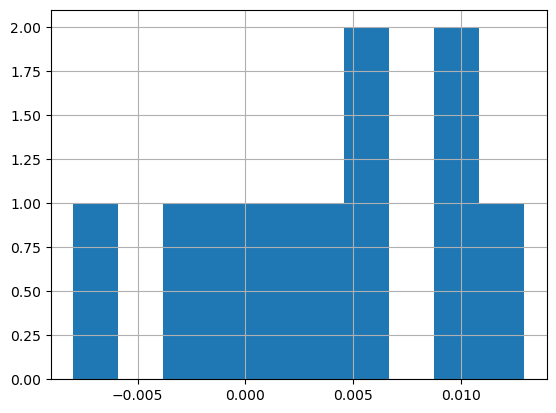

In [86]:
# filteredの値がTrueの場合、closeの値を取得
print(len(ohlcvs[ohlcvs['filtered']]))
print(ohlcvs[ohlcvs['filtered']]['entry_diff'].hist())

In [87]:
# 1分後の変動が0.01以上の場合、openで取得を検討した場合
#    - (close t0 - close t1) < -0.01の場合、next_open best_bidでentryし、next_closeでexitする
# 累積利益率を計算
profit = ohlcvs[ohlcvs['filtered']]['entry_diff'].cumsum()
print(profit.describe())

count    10.000000
mean      0.024580
std       0.009838
min       0.009105
25%       0.017689
50%       0.026711
75%       0.031595
max       0.036972
Name: entry_diff, dtype: float64


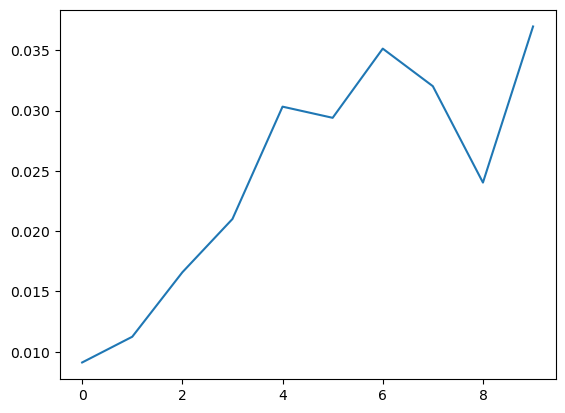

In [88]:
# re index
profit = profit.reset_index(drop=True)
plt.plot(profit)

In [89]:
# 収益機会の数
print(len(profit) / len(ohlcvs))

3.7741545893719805e-05


In [90]:
fee = len(profit) * 2 * fee_rate
print(fee)

0.011000000000000001


In [91]:
# 手数料を引いた見込み利益率
print(profit[len(profit)-1] - fee)

0.025971964122107463
